In [1]:
!pip install pandas matplotlib seaborn

# Model Inference and Benchmarking Notebook

This notebook performs model inference using a specified language model and benchmarks its performance across different prompts, output lengths, and batch sizes. The following metrics are measured:

- **Time To First Token (TTFT)**: Time taken to generate the first token after the prompt is processed.
- **Time Per Output Token (TPOT)**: Average time taken to generate each subsequent token.
- **Latency**: Total time to generate the complete output.
- **Throughput**: Number of output tokens generated per second across all requests.

The results are aggregated into a pandas DataFrame and visualized using matplotlib.

In [2]:
# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, TextIteratorStreamer
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import threading

%matplotlib inline

## Load the Model and Tokenizer

Specify the model path and load the tokenizer and model with the desired configurations.

In [3]:
# Load the tokenizer and model
model_path = 'mgoin/Nemotron-4-340B-Instruct-hf'
# model_path = 'nvidia/Minitron-4B-Base'

tokenizer = AutoTokenizer.from_pretrained(model_path)
# Check if the tokenizer has a pad_token
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
        print("Pad token not found. Using eos_token as pad_token.")

dtype = torch.bfloat16
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=dtype,
    device_map="auto"
)

Pad token not found. Using eos_token as pad_token.


Using the `SDPA` attention implementation on multi-gpu setup with ROCM may lead to performance issues due to the FA backend. Disabling it to use alternative backends.


Loading checkpoint shards:   0%|          | 0/189 [00:00<?, ?it/s]

## Define Benchmarking Functions

To capture **TTFT** and **TPOT**, we utilize a custom `Streamer` mechanism during generation.

In [4]:
from transformers.generation.streamers import BaseStreamer
from queue import Queue
from typing import Optional

class BatchTextIteratorStreamer(BaseStreamer):
    """
    Streamer that supports batch size >1. It stores print-ready text in queues, one per sequence.
    """

    def __init__(
        self, tokenizer, batch_size: int, skip_prompt: bool = False, timeout: Optional[float] = None, **decode_kwargs
    ):
        self.tokenizer = tokenizer
        self.skip_prompt = skip_prompt
        self.decode_kwargs = decode_kwargs
        self.batch_size = batch_size

        # Variables used in the streaming process
        self.token_caches = [[] for _ in range(batch_size)]
        self.print_lens = [0 for _ in range(batch_size)]
        self.next_tokens_are_prompt = [True for _ in range(batch_size)]

        self.text_queues = [Queue() for _ in range(batch_size)]
        self.stop_signal = None
        self.timeout = timeout

    def put(self, value):
        """
        Receives a batch of tokens, decodes them, and puts the decoded texts in the queues.
        """
        if len(value.shape) == 0:
            raise ValueError("Value should have batch dimension")

        batch_size = value.shape[0]
        if batch_size != self.batch_size:
            raise ValueError(f"Expected batch size {self.batch_size}, got {batch_size}")

        for i in range(batch_size):
            if self.skip_prompt and self.next_tokens_are_prompt[i]:
                self.next_tokens_are_prompt[i] = False
                continue

            token = value[i]
            self.token_caches[i].append(token.item())
            text = self.tokenizer.decode(self.token_caches[i], **self.decode_kwargs)

            # Output the new text since last time
            printable_text = text[self.print_lens[i]:]
            self.print_lens[i] += len(printable_text)

            self.on_finalized_text(printable_text, i)

    def end(self):
        """Flushes any remaining cache and puts a stop signal in each queue."""
        for i in range(self.batch_size):
            # Flush the cache, if it exists
            if len(self.token_caches[i]) > 0:
                text = self.tokenizer.decode(self.token_caches[i], **self.decode_kwargs)
                printable_text = text[self.print_lens[i]:]
                self.token_caches[i] = []
                self.print_lens[i] = 0
            else:
                printable_text = ""

            self.next_tokens_are_prompt[i] = True
            self.on_finalized_text(printable_text, i, stream_end=True)

    def on_finalized_text(self, text: str, index: int, stream_end: bool = False):
        """Puts the new text in the corresponding queue."""
        self.text_queues[index].put(text, timeout=self.timeout)
        if stream_end:
            self.text_queues[index].put(self.stop_signal, timeout=self.timeout)

    def get_stream(self, index: int):
        """Returns an iterator for the text of the sequence at index."""
        return BatchTextIterator(self.text_queues[index], self.stop_signal, self.timeout)

class BatchTextIterator:
    def __init__(self, text_queue, stop_signal, timeout):
        self.text_queue = text_queue
        self.stop_signal = stop_signal
        self.timeout = timeout

    def __iter__(self):
        return self

    def __next__(self):
        value = self.text_queue.get(timeout=self.timeout)
        if value == self.stop_signal:
            raise StopIteration()
        else:
            return value

In [5]:
def benchmark_inference_with_streamer(model, tokenizer, prompt, output_length, batch_size):
    """
    Benchmarks the model's inference performance using BatchTextIteratorStreamer.
    
    Args:
        model: The language model.
        tokenizer: The tokenizer.
        prompt (str): The input prompt.
        output_length (int): Number of tokens to generate.
        batch_size (int): Number of parallel requests.
        
    Returns:
        Dict containing benchmarking metrics.
    """
    import threading
    import time
    from transformers import GenerationConfig

    # Prepare batched inputs
    prompts = [prompt] * batch_size
    inputs = tokenizer(prompts, return_tensors='pt', padding=True).to(model.device)

    # Define generation configuration
    generation_config = GenerationConfig(
        max_new_tokens=output_length,
        do_sample=False,
    )

    # Initialize the BatchTextIteratorStreamer
    streamer = BatchTextIteratorStreamer(tokenizer, batch_size=batch_size, skip_prompt=True)

    # Function to run generation
    def generate():
        model.generate(
            **inputs,
            generation_config=generation_config,
            streamer=streamer,
        )

    # Start the generation in a separate thread
    gen_thread = threading.Thread(target=generate)
    gen_thread.start()

    # Initialize timing data
    token_times = [[] for _ in range(batch_size)]
    start_time = None

    # Get iterators for each sequence
    streams = [streamer.get_stream(i) for i in range(batch_size)]

    # Initialize counters for each sequence
    token_counters = [0] * batch_size

    # Iterate over tokens as they are generated
    while True:
        any_active = False
        for i in range(batch_size):
            if token_counters[i] < output_length:
                try:
                    generated_text = next(streams[i])
                    current_time = time.time()
                    if start_time is None:
                        start_time = current_time
                    # Record the time for the token
                    token_times[i].append(current_time - start_time)
                    token_counters[i] += 1
                    any_active = True
                except StopIteration:
                    pass  # This stream has ended
        if not any_active:
            break

    # Wait for the generation thread to finish
    gen_thread.join()

    # Now, compute metrics
    ttft_list = []
    tpot_list = []
    for t in token_times:
        if len(t) == 0:
            ttft_list.append(None)
            tpot_list.append(None)
            continue
        ttft = t[0]
        if len(t) > 1:
            token_intervals = [t[i] - t[i-1] for i in range(1, len(t))]
            tpot = sum(token_intervals) / len(token_intervals)
        else:
            tpot = 0
        ttft_list.append(ttft)
        tpot_list.append(tpot)

    # Calculate average metrics
    ttft_filtered = [ttft for ttft in ttft_list if ttft is not None]
    tpot_filtered = [tpot for tpot in tpot_list if tpot is not None]

    avg_ttft = sum(ttft_filtered) / len(ttft_filtered) if ttft_filtered else None
    avg_tpot = sum(tpot_filtered) / len(tpot_filtered) if tpot_filtered else None
    latency = avg_ttft + (avg_tpot * output_length) if (avg_ttft is not None and avg_tpot is not None) else None
    total_time = time.time() - start_time if start_time is not None else None
    throughput = (output_length * batch_size) / total_time if total_time and total_time > 0 else None

    return {
        'Batch Size': batch_size,
        'Output Length': output_length,
        'TTFT (s)': avg_ttft,
        'TPOT (s)': avg_tpot,
        'Latency (s)': latency,
        'Throughput (tokens/s)': throughput
    }

## Define Benchmark Parameters

Specify the prompts, output lengths, and batch sizes you want to benchmark.

In [6]:
prompts = [
    'Complete the paragraph: our solar system is',
]
'''
    'Explain the theory of relativity in simple terms.',
    'Write a short story about a brave knight.',
    'Describe the impact of climate change on marine life.'
]
'''

# output_lengths = [50, 100, 150]  # Number of tokens to generate
output_lengths = [128]  # Number of tokens to generate

batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]        # Number of parallel requests

## Run Benchmarks

Iterate over each combination of prompt, output length, and batch size to collect benchmarking metrics.

In [7]:
results = []

for prompt in prompts:
    for output_length in output_lengths:
        for batch_size in batch_sizes:
            print(f'Benchmarking - Prompt: "{prompt}", Output Length: {output_length}, Batch Size: {batch_size}')
            try:
                metrics = benchmark_inference_with_streamer(model, tokenizer, prompt, output_length, batch_size)
                metrics['Prompt'] = prompt
                results.append(metrics)
                if metrics['TTFT (s)'] is not None and metrics['TPOT (s)'] is not None:
                    print(f"TTFT: {metrics['TTFT (s)']:.4f}s, TPOT: {metrics['TPOT (s)']:.4f}s, Latency: {metrics['Latency (s)']:.4f}s, Throughput: {metrics['Throughput (tokens/s)']:.2f} tokens/s")
                else:
                    print("Metrics could not be calculated.")
            except Exception as e:
                print(f"An error occurred: {e}")
            print("---")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 1


/home/hotaisle/miniforge3/lib/python3.12/site-packages/transformers/models/nemotron/modeling_nemotron.py:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0000s, TPOT: 0.2340s, Latency: 29.9572s, Throughput: 4.31 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 2


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0000s, TPOT: 0.2359s, Latency: 30.1995s, Throughput: 8.54 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 4


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0000s, TPOT: 0.2418s, Latency: 30.9554s, Throughput: 16.67 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 8


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0001s, TPOT: 0.2486s, Latency: 31.8195s, Throughput: 32.43 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 16


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0002s, TPOT: 0.2628s, Latency: 33.6449s, Throughput: 61.34 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 32


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0004s, TPOT: 0.2946s, Latency: 37.7128s, Throughput: 109.42 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 64


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0001s, TPOT: 0.3708s, Latency: 47.4624s, Throughput: 173.85 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 128


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0003s, TPOT: 0.5800s, Latency: 74.2388s, Throughput: 222.26 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 256


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0018s, TPOT: 1.0719s, Latency: 137.2089s, Throughput: 240.51 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 512


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TTFT: 0.0010s, TPOT: 1.7628s, Latency: 225.6442s, Throughput: 292.43 tokens/s
---
Benchmarking - Prompt: "Complete the paragraph: our solar system is", Output Length: 128, Batch Size: 1024
TTFT: 0.0111s, TPOT: 3.8790s, Latency: 496.5268s, Throughput: 265.81 tokens/s
---


## Create a Pandas DataFrame

Convert the collected results into a pandas DataFrame for easier analysis and visualization.

In [8]:
# Create DataFrame
df = pd.DataFrame(results)

# Rearrange columns for better readability
cols = ['Prompt', 'Batch Size', 'Output Length', 'TTFT (s)', 'TPOT (s)', 'Latency (s)', 'Throughput (tokens/s)']
df = df[cols]

df

,Prompt,Batch Size,Output Length,TTFT (s),TPOT (s),Latency (s),Throughput (tokens/s)
0,Complete the paragraph: our solar system is,1,128,0.000000,0.234040,29.957160,4.306249
1,Complete the paragraph: our solar system is,2,128,0.000009,0.235934,30.199506,8.543277
2,Complete the paragraph: our solar system is,4,128,0.000010,0.241839,30.955373,16.668872
3,Complete the paragraph: our solar system is,8,128,0.000131,0.248589,31.819548,32.430633
4,Complete the paragraph: our solar system is,16,128,0.000240,0.262849,33.644887,61.335794
5,Complete the paragraph: our solar system is,32,128,0.000422,0.294628,37.712771,109.422629
6,Complete the paragraph: our solar system is,64,128,0.000142,0.370799,47.462434,173.853317
7,Complete the paragraph: our solar system is,128,128,0.000282,0.579988,74.238779,222.259954
8,Complete the paragraph: our solar system is,256,128,0.001828,1.071930,137.208901,240.509882
9,Complete the paragraph: our solar system is,512,128,0.000953,1.762838,225.644205,292.431579


## Analyze and Visualize the Results

Use seaborn and matplotlib to create visualizations of the benchmarking metrics across different batch sizes and output lengths.

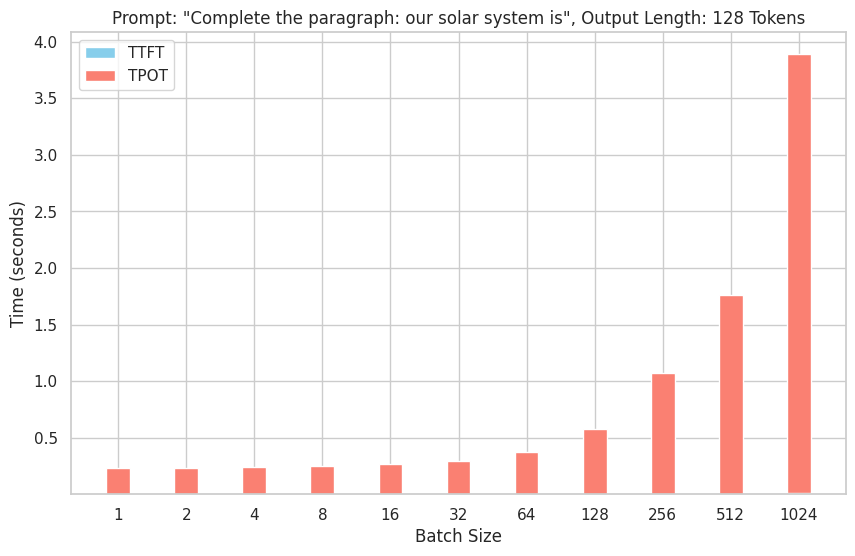

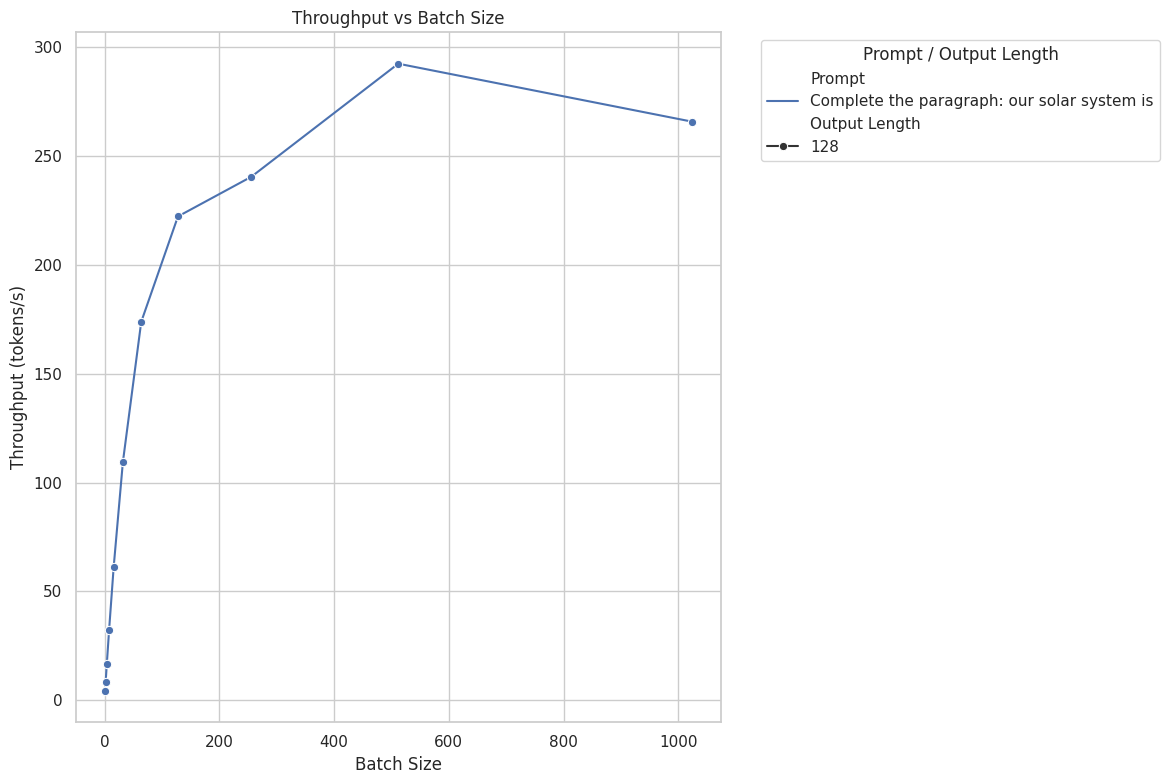

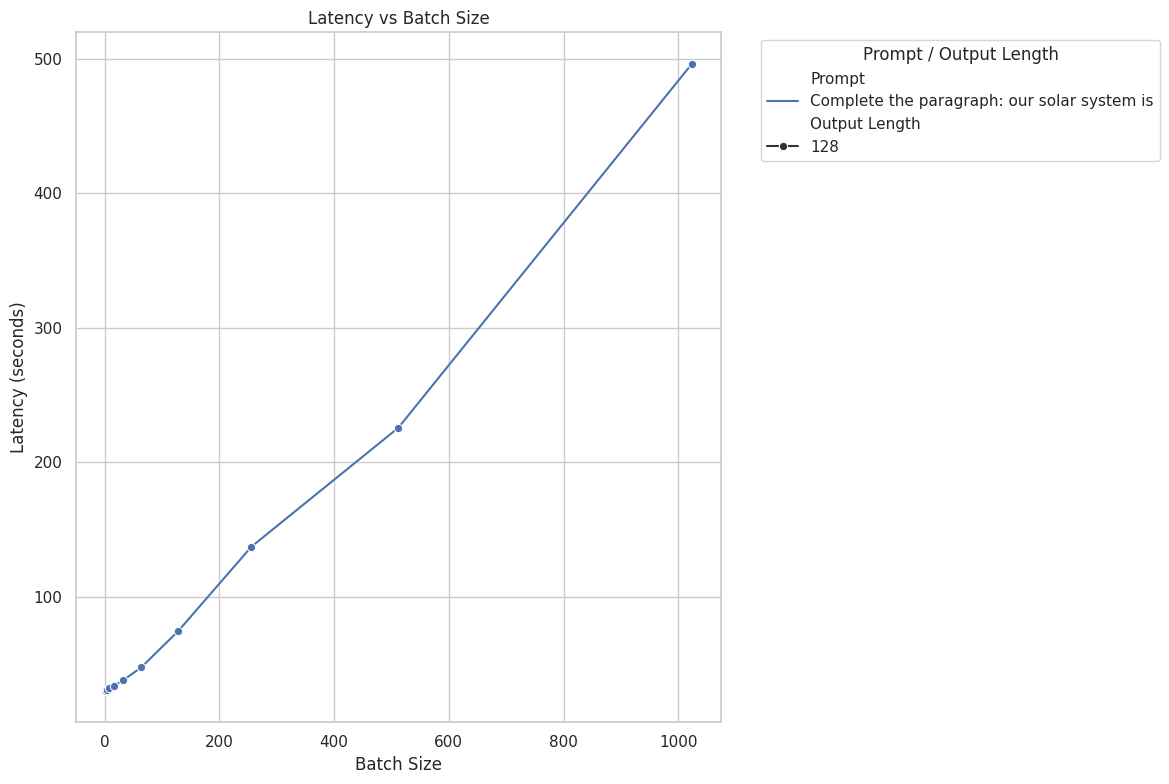

In [9]:
sns.set(style="whitegrid")

# Plot TTFT and TPOT vs Batch Size for each Prompt and Output Length
for prompt in prompts:
    for output_length in output_lengths:
        subset = df[(df['Prompt'] == prompt) & (df['Output Length'] == output_length)]
        if subset.empty:
            continue
        plt.figure(figsize=(10, 6))
        # Create a bar plot with two bars per batch size
        x = subset['Batch Size'].astype(str)
        width = 0.35  # Width of the bars

        plt.bar(x, subset['TTFT (s)'], width, label='TTFT', color='skyblue')
        plt.bar(x, subset['TPOT (s)'], width, bottom=subset['TTFT (s)'], label='TPOT', color='salmon')

        plt.title(f'Prompt: "{prompt}", Output Length: {output_length} Tokens')
        plt.xlabel('Batch Size')
        plt.ylabel('Time (seconds)')
        plt.legend()
        plt.show()

# Plot Throughput vs Batch Size
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Batch Size', y='Throughput (tokens/s)', hue='Prompt', style='Output Length', markers=True, dashes=False)
plt.title('Throughput vs Batch Size')
plt.ylabel('Throughput (tokens/s)')
plt.xlabel('Batch Size')
plt.legend(title='Prompt / Output Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot Latency vs Batch Size
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Batch Size', y='Latency (s)', hue='Prompt', style='Output Length', markers=True, dashes=False)
plt.title('Latency vs Batch Size')
plt.ylabel('Latency (seconds)')
plt.xlabel('Batch Size')
plt.legend(title='Prompt / Output Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()